In [1]:
import torch
import numpy as np
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report

from scarches.dataset.trvae.data_handling import remove_sparsity
from lataq.models import EMBEDCVAE
from lataq.exp_dict import EXPERIMENT_INFO

sc.settings.set_figure_params(dpi=200, frameon=False)
sc.set_figure_params(dpi=500)
plt.rcParams['figure.figsize'] = (5, 5)
torch.set_printoptions(precision=3, sci_mode=False, edgeitems=7)

%load_ext autoreload
%autoreload 2

In [2]:
PARAMS = {
    'EPOCHS': 100,                                      #TOTAL TRAINING EPOCHS
    'N_PRE_EPOCHS': 80,                                #EPOCHS OF PRETRAINING WITHOUT LANDMARK LOSS
    'DATA_DIR': '../../lataq_reproduce/data',          #DIRECTORY WHERE THE DATA IS STORED
    'DATA': 'pancreas',                                #DATA USED FOR THE EXPERIMENT
    'EARLY_STOPPING_KWARGS': {                         #KWARGS FOR EARLY STOPPING
        "early_stopping_metric": "val_landmark_loss",  ####value used for early stopping
        "mode": "min",                                 ####choose if look for min or max
        "threshold": 0,
        "patience": 20,
        "reduce_lr": True,
        "lr_patience": 13,
        "lr_factor": 0.1,
    },
    'LABELED_LOSS_METRIC': 'dist',           
    'UNLABELED_LOSS_METRIC': 'dist',
    'LATENT_DIM': 25,
    'ALPHA_EPOCH_ANNEAL': 1e6,
    'CLUSTERING_RES': 2,
    'HIDDEN_LAYERS': 3,
    'ETA': 10,
}

In [3]:
EXP_PARAMS = EXPERIMENT_INFO[PARAMS['DATA']]
adata = sc.read(
    f'{PARAMS["DATA_DIR"]}/{EXP_PARAMS["file_name"]}'
)
condition_key = EXP_PARAMS['condition_key']
cell_type_key = EXP_PARAMS['cell_type_key']
reference = EXP_PARAMS['reference']
query = EXP_PARAMS['query']
adata.obs['query'] = adata.obs[condition_key].isin(query)
adata.obs['query'] = adata.obs['query'].astype('category')
source_adata = adata[adata.obs.study.isin(reference)].copy()
target_adata = adata[adata.obs.study.isin(query)].copy()

In [4]:
lataq_model = EMBEDCVAE(
    adata=source_adata,
    condition_key=condition_key,
    cell_type_keys=cell_type_key,
    hidden_layer_sizes=[128]*int(PARAMS['HIDDEN_LAYERS']),
    latent_dim=PARAMS['LATENT_DIM'],
)

Embedding dictionary:
 	Num conditions: 7
 	Embedding dim: 10
Encoder Architecture:
	Input Layer in, out and cond: 4000 128 0
	Hidden Layer 1 in/out: 128 128
	Hidden Layer 2 in/out: 128 128
	Mean/Var Layer in/out: 128 25
Decoder Architecture:
	First Layer in, out and cond:  25 128 10
	Hidden Layer 1 in/out: 128 128
	Hidden Layer 2 in/out: 128 128
	Output Layer in/out:  128 4000 



In [5]:
lataq_model.train(
    n_epochs=PARAMS['EPOCHS'],
    pretraining_epochs=PARAMS['N_PRE_EPOCHS'],
    early_stopping_kwargs=PARAMS['EARLY_STOPPING_KWARGS'],
    alpha_epoch_anneal=PARAMS['ALPHA_EPOCH_ANNEAL'],
    eta=PARAMS['ETA'],
    clustering_res=PARAMS['CLUSTERING_RES'],
    labeled_loss_metric=PARAMS['LABELED_LOSS_METRIC'],
    unlabeled_loss_metric=PARAMS['UNLABELED_LOSS_METRIC'],
)

 |████████████████████| 100.0%  - val_loss: 1010.1286676580 - val_trvae_loss: 1004.1473333185 - val_landmark_loss: 5.9813278263 - val_labeled_loss: 0.5981327688
Saving best state of network...
Best State was in Epoch 95


In [6]:
lataq_model.save('pancreas/', overwrite=True)

In [7]:
lataq_query = lataq_model.load_query_data(
    adata=target_adata,
    reference_model='pancreas/',
    labeled_indices=[],
)

AnnData object with n_obs × n_vars = 3289 × 4000
    obs: 'study', 'cell_type', 'pred_label', 'pred_score', 'query'
    obsm: 'X_seurat', 'X_symphony'
Embedding dictionary:
 	Num conditions: 9
 	Embedding dim: 10
Encoder Architecture:
	Input Layer in, out and cond: 4000 128 0
	Hidden Layer 1 in/out: 128 128
	Hidden Layer 2 in/out: 128 128
	Mean/Var Layer in/out: 128 25
Decoder Architecture:
	First Layer in, out and cond:  25 128 10
	Hidden Layer 1 in/out: 128 128
	Hidden Layer 2 in/out: 128 128
	Output Layer in/out:  128 4000 



In [8]:
lataq_query.train(
    n_epochs=PARAMS['EPOCHS'],
    early_stopping_kwargs=PARAMS['EARLY_STOPPING_KWARGS'],
    alpha_epoch_anneal=PARAMS['ALPHA_EPOCH_ANNEAL'],
    pretraining_epochs=PARAMS['N_PRE_EPOCHS'],
    clustering_res=PARAMS['CLUSTERING_RES'],
    eta=PARAMS['ETA'],
    labeled_loss_metric=PARAMS['LABELED_LOSS_METRIC'],
    unlabeled_loss_metric=PARAMS['UNLABELED_LOSS_METRIC'],
)

 |████████████████----| 80.0%  - val_loss: 1874.8219807943 - val_trvae_loss: 1874.8219807943
Initializing unlabeled landmarks with Leiden-Clustering with an unknown number of clusters.
Leiden Clustering succesful. Found 24 clusters.
 |████████████████████| 100.0%  - val_loss: 1866.2771402995 - val_trvae_loss: 1866.2320149740 - val_landmark_loss: 0.0451316747 - val_unlabeled_loss: 4.5131673813
Saving best state of network...
Best State was in Epoch 89


In [9]:
lataq_query.save('pancreas_wquery/', overwrite=True)

In [1]:
results_dict = lataq_query.classify(
    adata.X, 
    adata.obs[condition_key], 
    metric=PARAMS['LABELED_LOSS_METRIC'],
)
for i in range(len(cell_type_key)):
    preds = results_dict[cell_type_key[i]]['preds']
    probs = results_dict[cell_type_key[i]]['probs']
    classification_df = pd.DataFrame(
        classification_report(
            y_true=adata.obs[cell_type_key[i]], 
            y_pred=preds,
            output_dict=True
        )
    ).transpose()

NameError: name 'lataq_query' is not defined

In [ ]:
plt.plot(lataq_model.trainer.logs['epoch_loss'])

In [2]:
embedding = lataq_model.model.embedding.weight.detach().cpu().numpy()
from sklearn.decomposition import KernelPCA
pca = KernelPCA(n_components=2, kernel='cosine')
emb_pca = pca.fit_transform(embedding)

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
import seaborn as sns
sns.scatterplot(emb_pca[:, 0], emb_pca[:, 1], source_adata.obs[condition_key].unique(), ax=ax)
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
for i, c in enumerate(source_adata.obs[condition_key].unique()):
    ax.plot([0, emb_pca[i, 0]], [0, emb_pca[i, 1]])
    ax.text(emb_pca[i, 0], emb_pca[i, 1], c)
sns.despine()

NameError: name 'lataq_model' is not defined

In [3]:
embedding = lataq_query.model.embedding.weight.detach().cpu().numpy()
from sklearn.decomposition import KernelPCA
#pca = KernelPCA(n_components=2, kernel='linear')
#emb_pca = pca.fit_transform(embedding)
emb_pca = pca.transform(embedding)
conditions = lataq_query.conditions_
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
import seaborn as sns
sns.scatterplot(emb_pca[:, 0], emb_pca[:, 1], conditions, ax=ax)
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
for i, c in enumerate(conditions):
    ax.plot([0, emb_pca[i, 0]], [0, emb_pca[i, 1]])
    ax.text(emb_pca[i, 0], emb_pca[i, 1], c)
sns.despine()

NameError: name 'lataq_query' is not defined

In [31]:
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances 

(9, 9)

<AxesSubplot:>

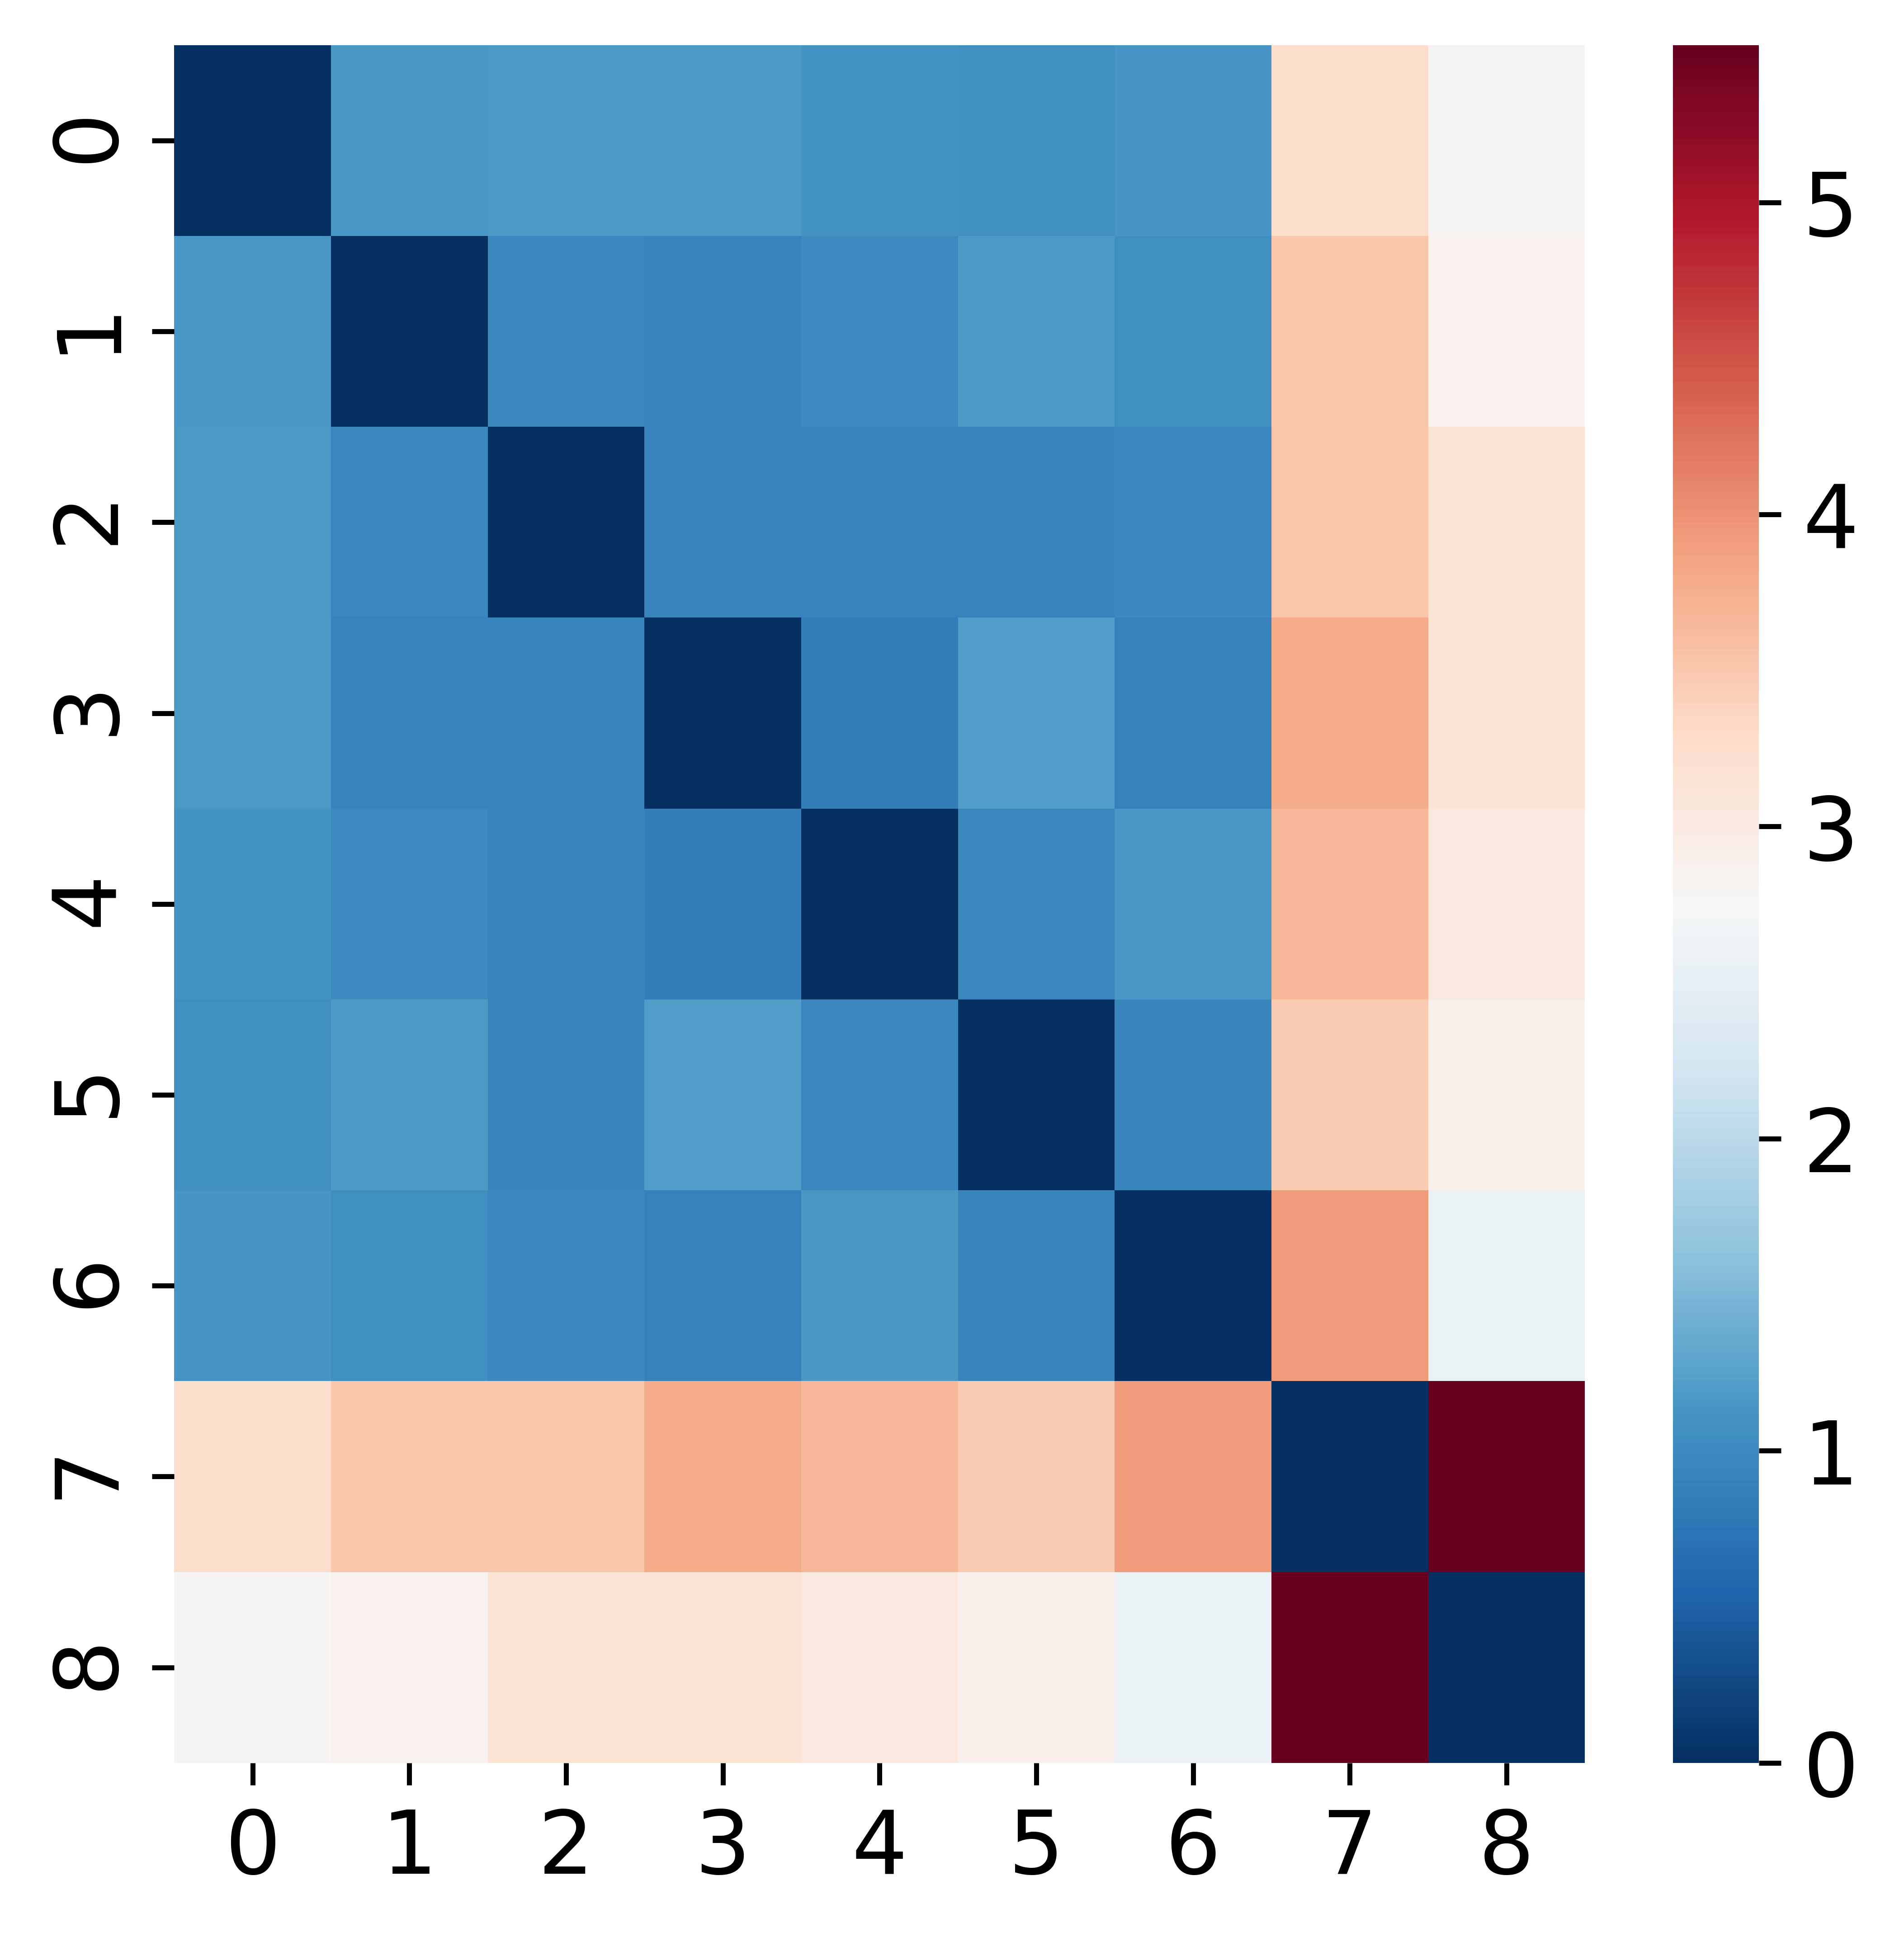

In [32]:
sns.heatmap(euclidean_distances(embedding), cmap='RdBu_r')

In [38]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
sns.heatmap(
    1 - cosine_similarity(embedding), 
    cmap='Reds', 
    annot=True, 
    fmt='.2f',
    ax=ax
)

<AxesSubplot:>

In [53]:
cos_dist = 1 - cosine_similarity(embedding)
np.fill_diagonal(cos_dist, np.inf)
min_val = np.min(cos_dist, axis=1)
min_val

array([0.54, 0.87, 0.89, 0.84, 0.84, 0.82, 0.5 , 0.54, 0.5 ],
      dtype=float32)

In [36]:
np.min(cosine_similarity(embedding), axis=0)

array([-0.24, -0.54, -0.35, -0.72, -0.51, -0.72, -0.52, -0.52, -0.48],
      dtype=float32)

In [22]:
conditions = lataq_query.conditions_
conditions

['fluidigmc1',
 'inDrop1',
 'inDrop2',
 'inDrop3',
 'inDrop4',
 'smarter',
 'smartseq2',
 'celseq',
 'celseq2']

/home/icb/carlo.dedonno/anaconda3/envs/lataq_cuda/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y, hue. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


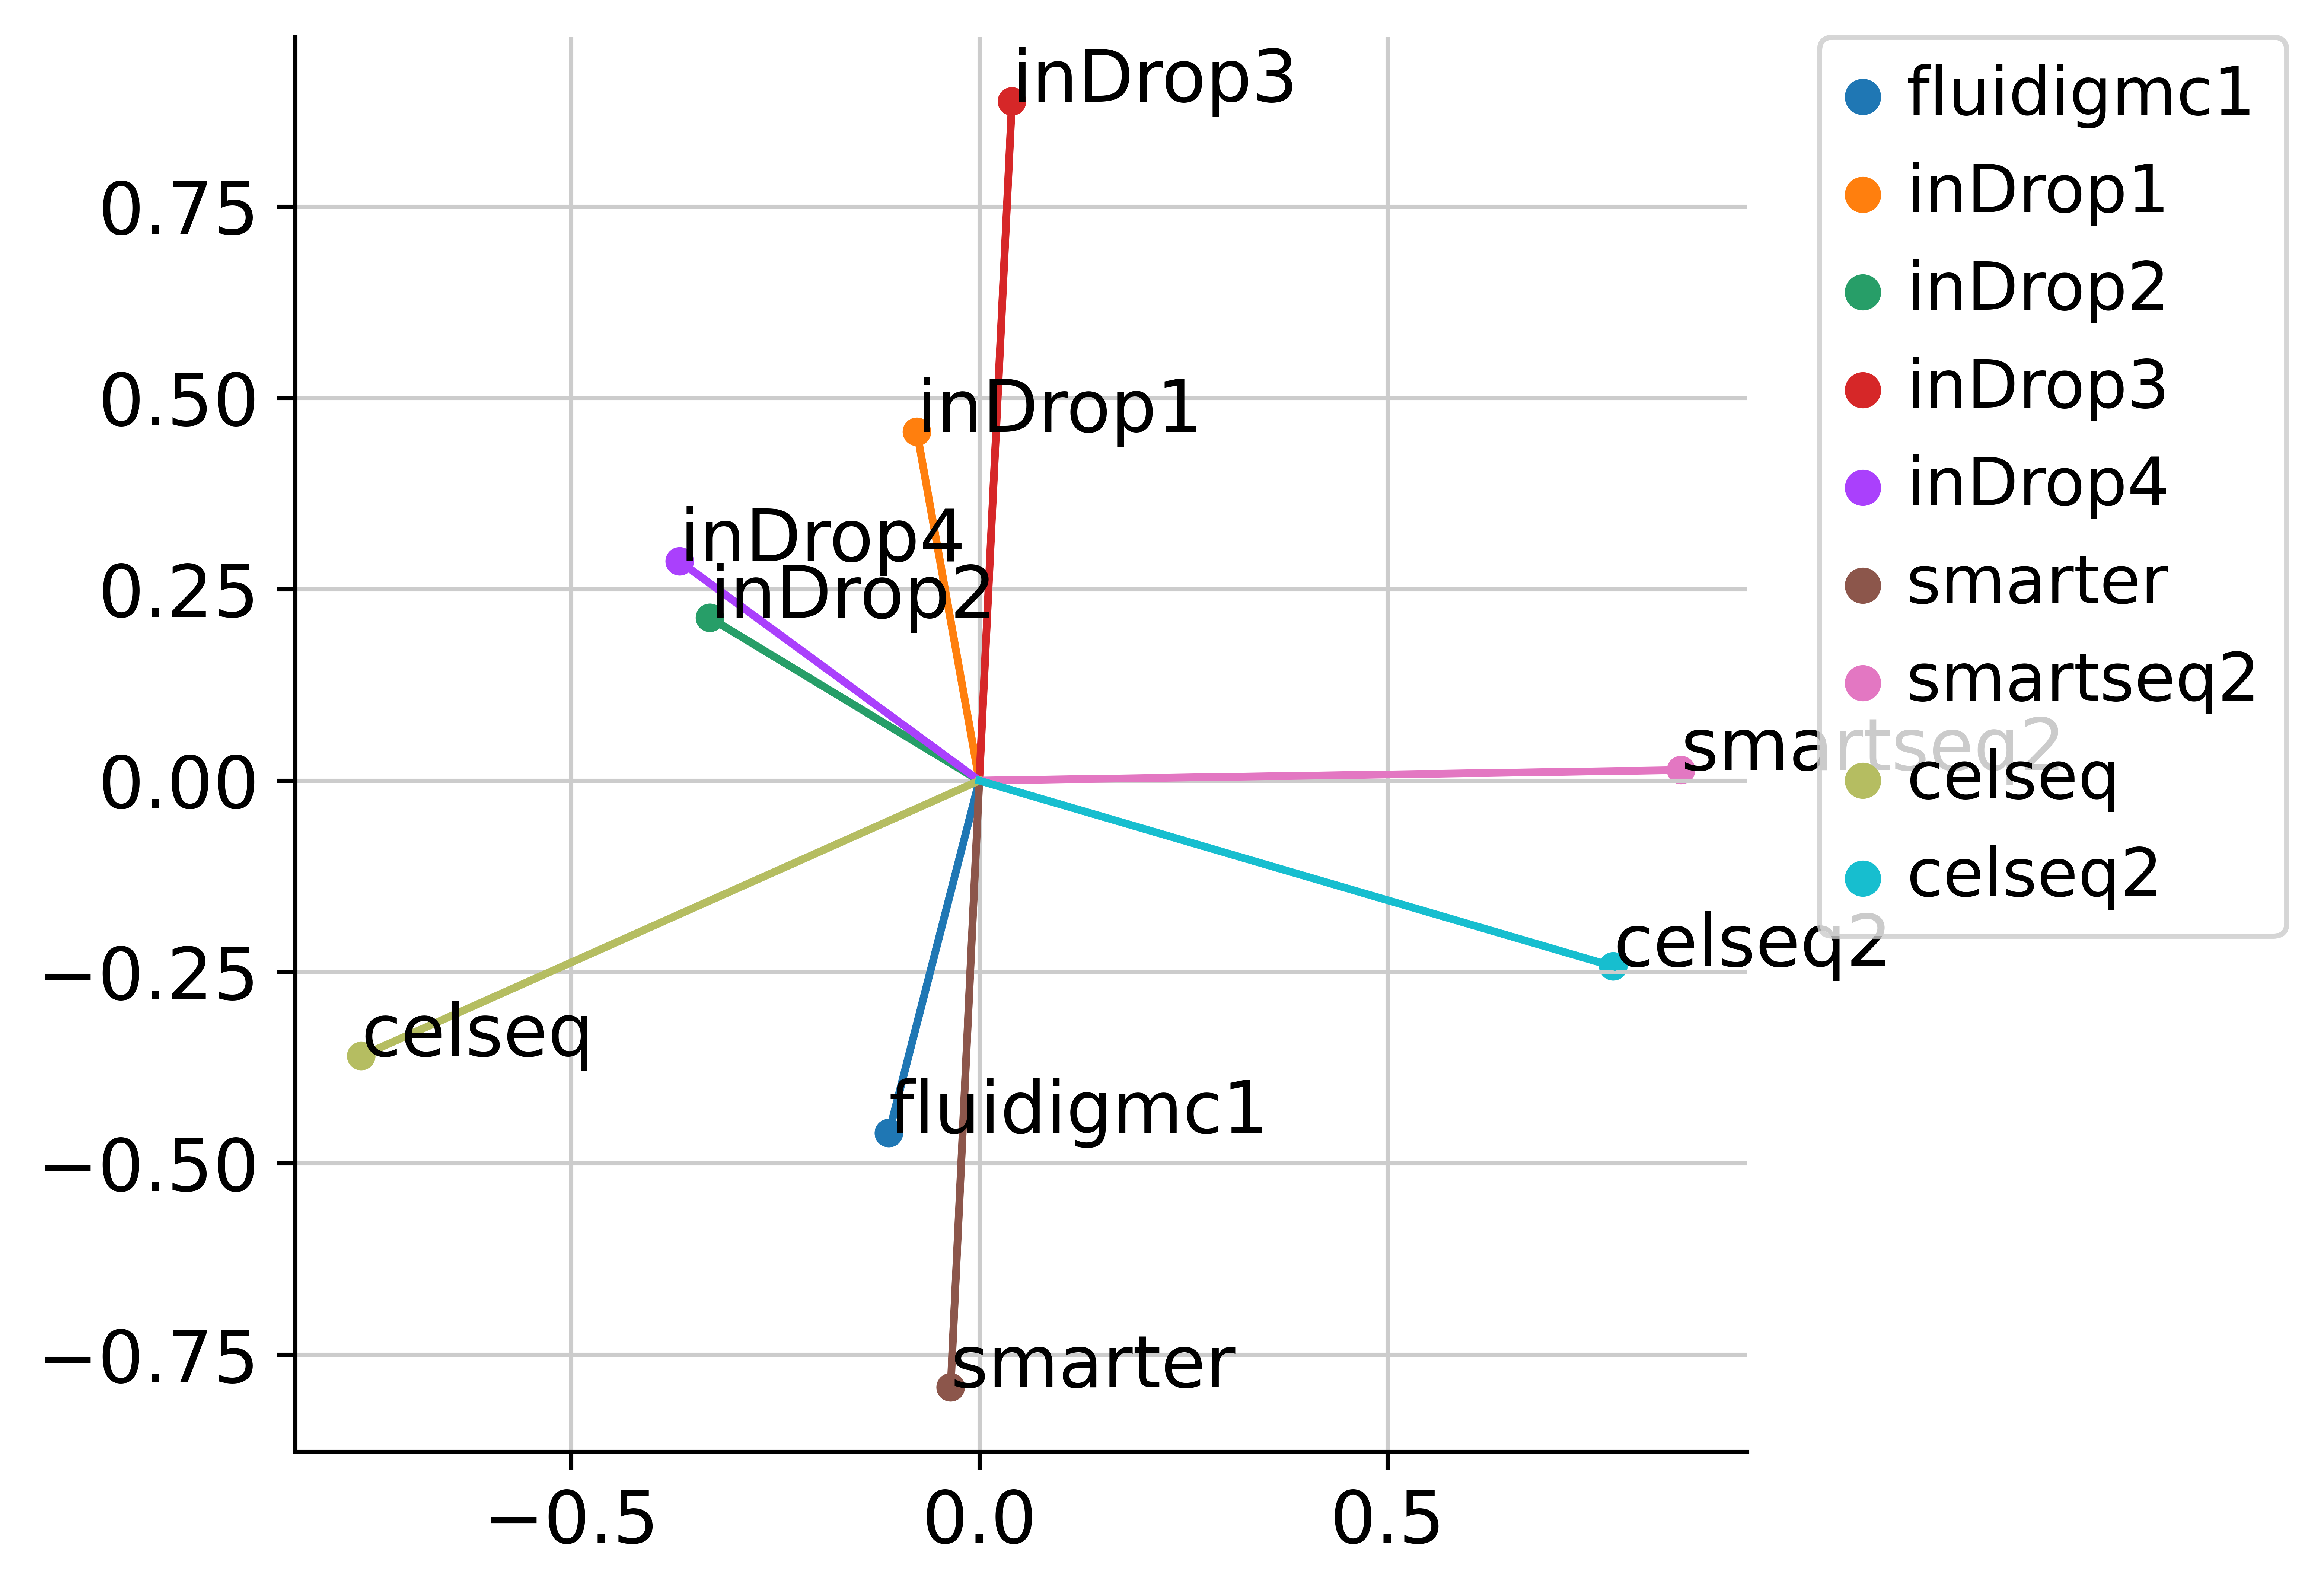

In [39]:
embedding = lataq_query.model.embedding.weight.detach().cpu().numpy()
from sklearn.decomposition import KernelPCA
pca = KernelPCA(n_components=2, kernel='cosine')
emb_pca = pca.fit_transform(embedding)
emb_pca = pca.transform(embedding)
conditions = lataq_query.conditions_
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
import seaborn as sns
sns.scatterplot(emb_pca[:, 0], emb_pca[:, 1], conditions, ax=ax)
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
for i, c in enumerate(conditions):
    ax.plot([0, emb_pca[i, 0]], [0, emb_pca[i, 1]])
    ax.text(emb_pca[i, 0], emb_pca[i, 1], c)
sns.despine()

{'cell_type': {'preds': array(['epsilon', 'epsilon', 'gamma', 'epsilon', 'gamma', 'epsilon',
       'gamma', ..., 'epsilon', 'schwann', 'quiescent_stellate',
       'quiescent_stellate', 'quiescent_stellate', 'quiescent_stellate',
       'quiescent_stellate'], dtype='<U18'), 'probs': array([0.45, 0.46, 0.46, 0.47, 0.46, 0.46, 0.47, ..., 0.46, 0.34, 0.33,
       0.33, 0.33, 0.33, 0.33], dtype=float32)}}


... storing 'batch' as categorical


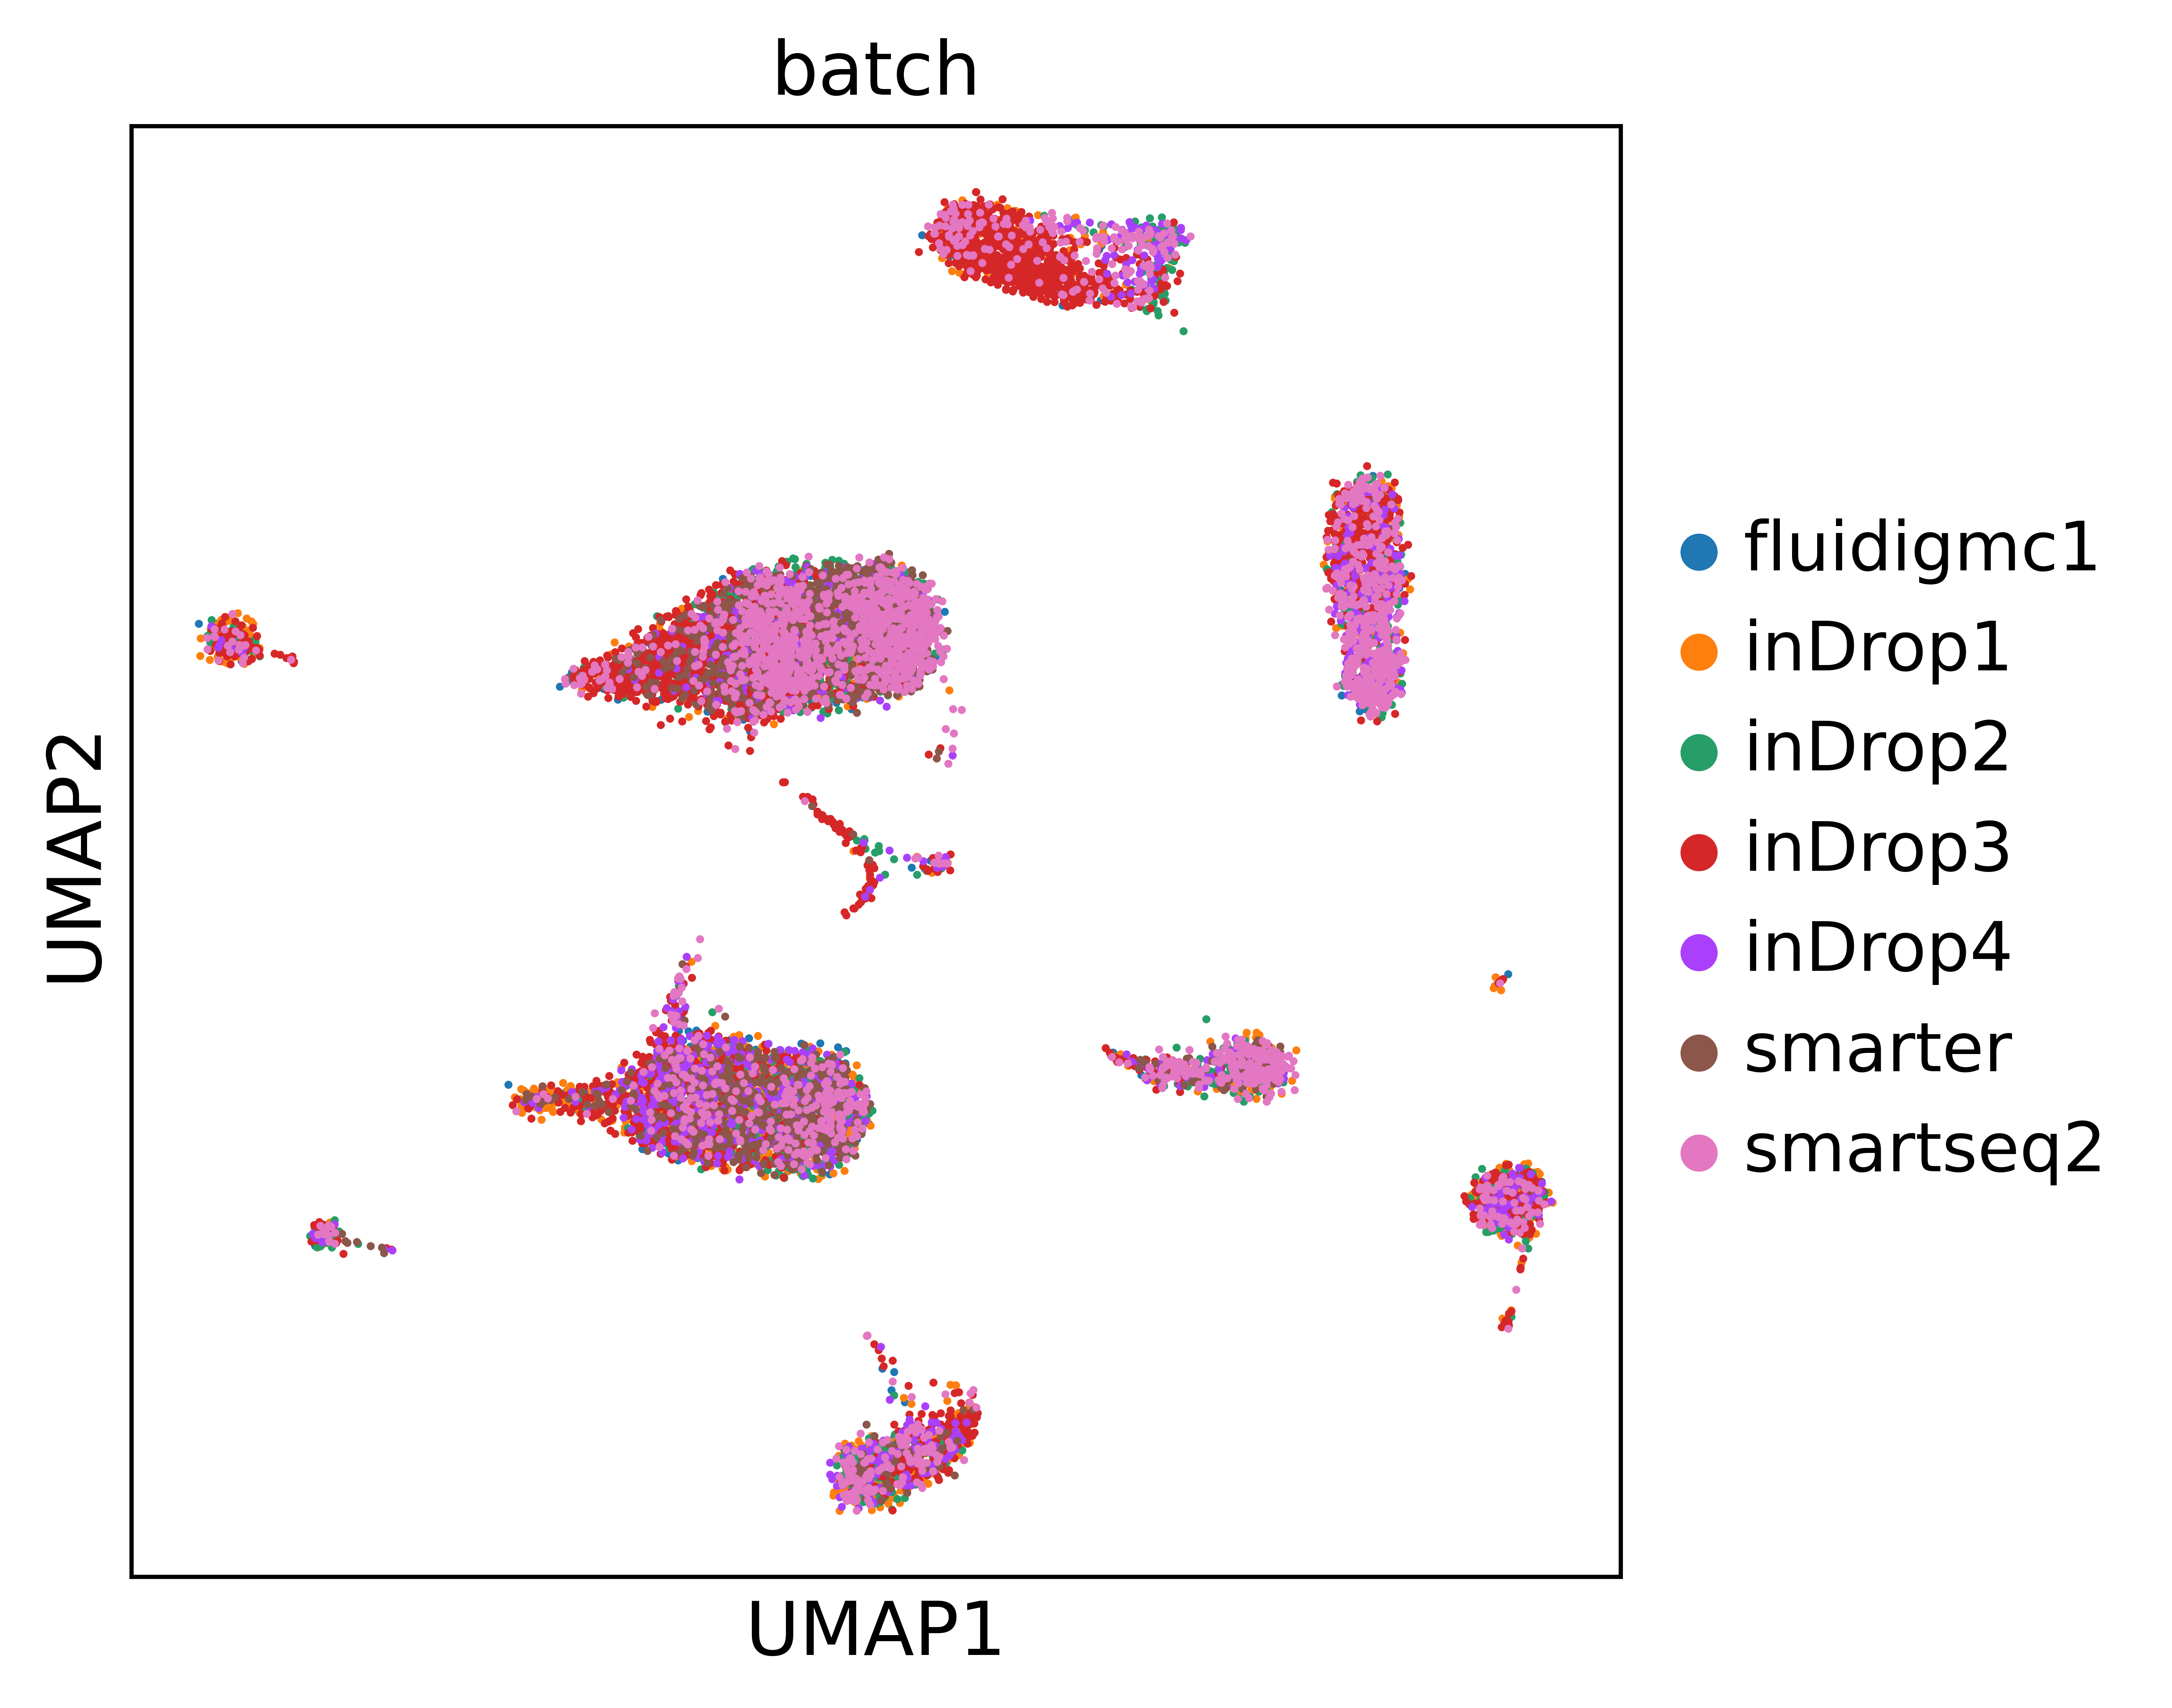

In [17]:
data_latent = lataq_query.get_latent(
    source_adata.X, 
    source_adata.obs[condition_key].values
)
adata_latent = sc.AnnData(data_latent)
adata_latent.obs['batch'] = source_adata.obs[condition_key].tolist()
results_dict = lataq_query.classify(
    source_adata.X, 
    source_adata.obs[condition_key], 
    metric='dist'
)
print(results_dict)
sc.pp.neighbors(adata_latent)
sc.tl.umap(adata_latent)
sc.pl.umap(adata_latent, color='batch')

{'cell_type': {'preds': array(['epsilon', 'epsilon', 'gamma', 'epsilon', 'epsilon', 'epsilon',
       'gamma', ..., 'activated_stellate', 'quiescent_stellate',
       'quiescent_stellate', 'quiescent_stellate', 'quiescent_stellate',
       'quiescent_stellate', 'quiescent_stellate'], dtype='<U18'), 'probs': array([0.45, 0.46, 0.45, 0.45, 0.45, 0.46, 0.46, ..., 0.33, 0.33, 0.33,
       0.33, 0.33, 0.33, 0.32], dtype=float32)}}


... storing 'batch' as categorical


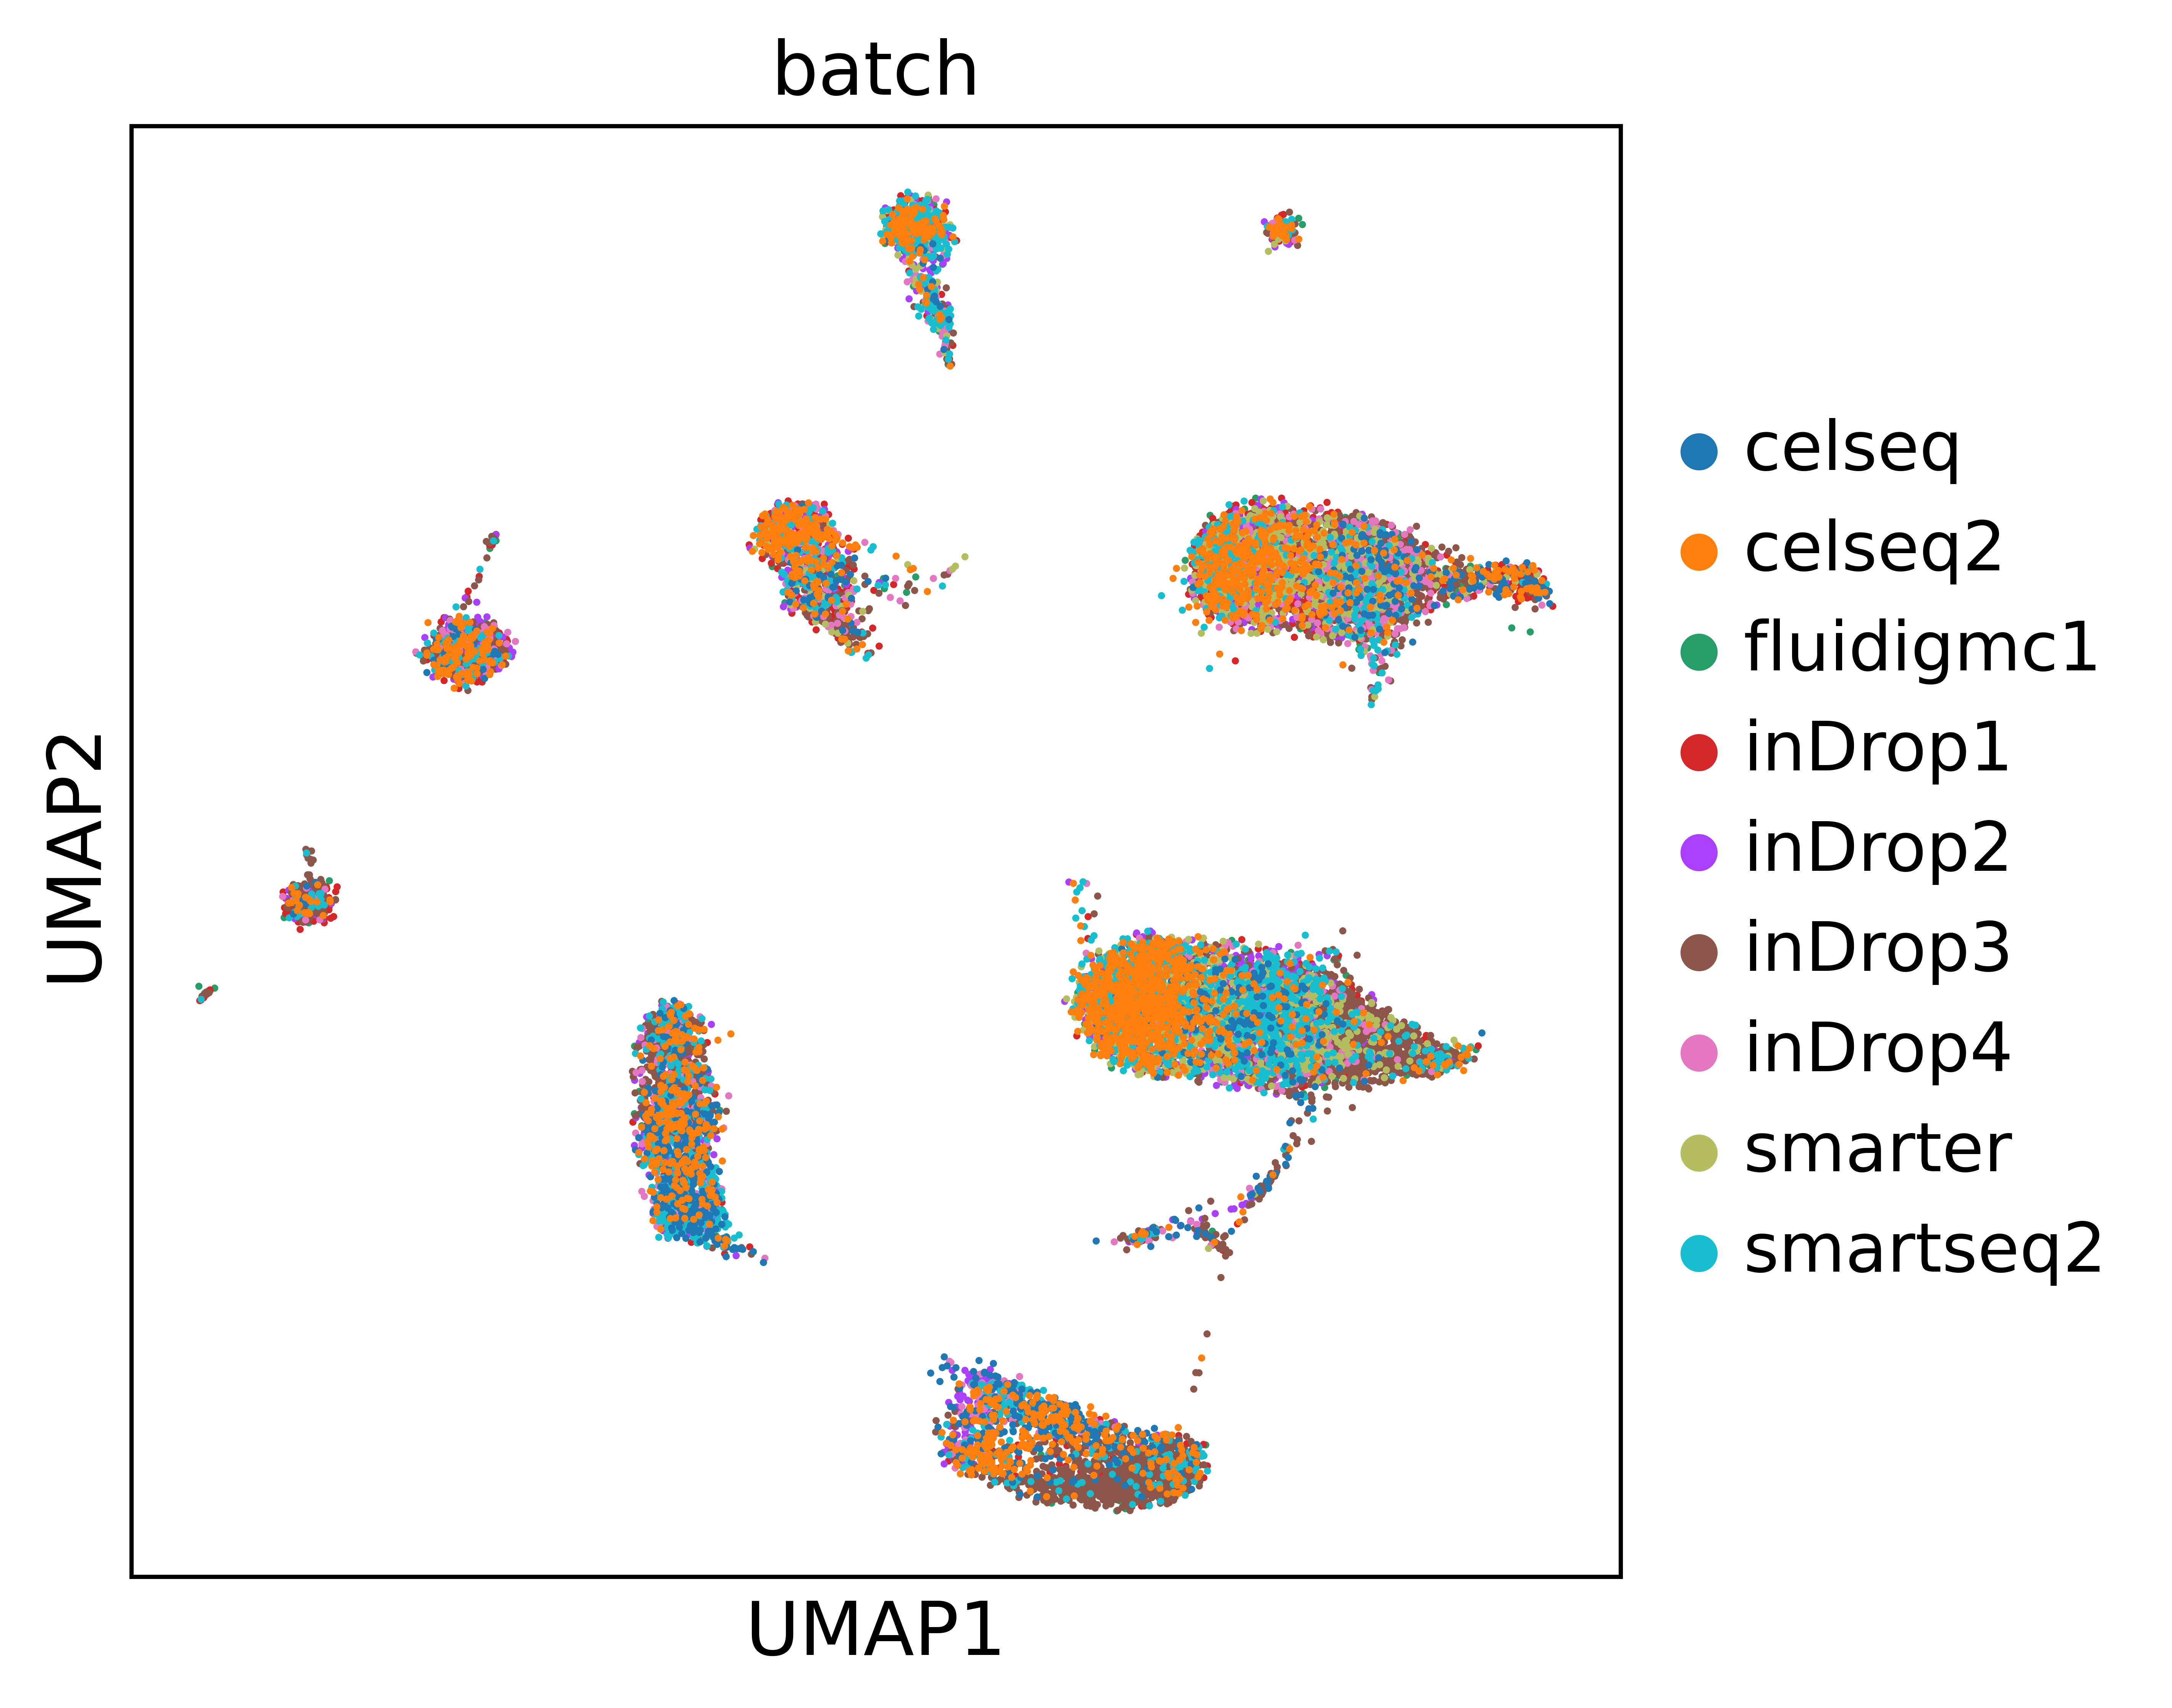

KeyError: 'query'

In [18]:
data_latent = lataq_query.get_latent(
    adata.X, 
    adata.obs[condition_key].values
)
adata_latent = sc.AnnData(data_latent)
adata_latent.obs['batch'] = adata.obs[condition_key].tolist()
results_dict = lataq_query.classify(
    adata.X, 
    adata.obs[condition_key], 
    metric='dist'
)
print(results_dict)
sc.pp.neighbors(adata_latent)
sc.tl.umap(adata_latent)
sc.pl.umap(adata_latent, color='batch')
adata_latent.obs['query'] = adata_latent.obs['query'].astype('category')
sc.pl.umap(adata_latent, color='query')